In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
import gcm_filters
import xrft
from dask.diagnostics import ProgressBar
from rechunker import rechunk
import zarr

In [4]:
#u_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr',decode_cf=False)
#v_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr',decode_cf=False)
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')#,decode_cf=False)

eta_merged = eta_merged.isel(time=slice(1,1800))
#u_merged = u_merged.isel(time=slice(1,1800))
#v_merged = v_merged.isel(time=slice(1,1800))

#eta_merged = eta_merged.drop_vars('time')

In [3]:
#eta_mean = eta_merged.Eta.mean('time')
#eta_mean.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr', append_dim='time')
eta_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_mean.zarr').Eta

In [55]:
#eta = eta_merged.Eta
#eta_nom = eta-eta_mean

In [56]:
#outdir='/swot/SUM03/spencer/swot_eta_nomean/'
#for i in range(0,1751):
#    if np.mod(i,10)==0:
#        print(i)
#    nt = 10368 + i*144
#    Nt = nt - 10368
#    eta = eta_nom.isel(time=i).fillna(0).values
#    output_binary_file(eta, os.path.join(outdir, 'eta_nom.%010d.data' % Nt))

In [4]:
eta = eta_merged.Eta.astype(np.float64)-eta_mean

# GCM filters section

In [5]:
wet_mask=xr.ones_like(eta)
wet_mask=wet_mask.where(eta!=0,0)


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


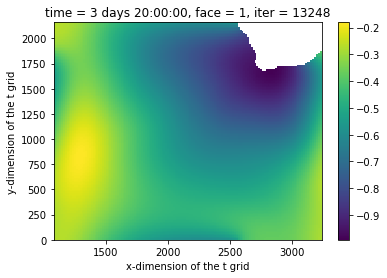

In [6]:
cor_fac = 15
eta_coarsened = eta.where(wet_mask.isel(time=20)>0).coarsen(i=cor_fac, j=cor_fac, boundary="pad").mean(keep_attrs=True)
wet_mask_coarsen = wet_mask.coarsen(i=cor_fac, j=cor_fac, boundary="pad").max(keep_attrs=True)

filter = gcm_filters.Filter(
    filter_scale=40,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask_coarsen.chunk({'i':-1,'j':-1,'time':1})}
)
filter
eta_filtered = filter.apply(eta_coarsened.chunk({'i':-1,'j':-1,'time':1}), dims=['i', 'j'])
eta_filtered.isel(time=20).plot(x='i')

In [7]:
eta_nobm = eta - eta_filtered.interp_like(eta.isel(time=20))

In [169]:
velmask = eta_nob.isel(time=0).where(np.isnan(eta_nob.isel(time=0)),1).where(np.isfinite(eta_nob.isel(time=0)),0)

In [20]:
def output_binary_file(data, fname, dtype=np.dtype('>f4')):
    data.astype(dtype).tofile(fname)

In [ ]:
outdir='/swot/SUM03/spencer/swot_eta_nobaro/'
for i in range(0,1751):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    eta = eta_nobm.isel(time=i).fillna(0).values
    output_binary_file(eta, os.path.join(outdir, 'eta_nobm.%010d.data' % Nt))

In [8]:
Etatarget = '/swot/SUM02/spencer/swot_agulhas_surf/baro_nom.zarr'
for i in range(0,1751):
    if np.mod(i,10)==0:
        print(i)
    eta_nobm_slice = eta_nobm.isel(time=[i])
    eta_nobm_slice.to_dataset(name='eta').to_zarr(Etatarget, append_dim='time')

0


/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750


# Rechunk in time so that tide fitting is easier

In [41]:
source = zarr.open('/swot/SUM02/spencer/swot_agulhas_surf/eta_long.zarr')
intermediate = "/swot/SUM02/spencer/swot_agulhas_surf/intermediate.zarr"
target = "/swot/SUM02/spencer/swot_agulhas_surf/eta_timechunks.zarr"

In [42]:
target_chunks = {
    'Eta': {'time':1752,'j':180,'i':180},
    'x': {'i':180, 'j':180},
    'y': {'i':180, 'j':180},
    'time': None, # don't rechunk this array
    'iter': None,
    'i': None,
    'j': None,
}

In [43]:
rechunked = rechunk(source, target_chunks=target_chunks,target_store=target,max_mem='800MB',temp_store=intermediate)#, target_chunks={'i':180, 'j':180,'time':1751}, target_store=target,max_mem=256000,temp_store=intermediate)

In [44]:
rechunked.execute();

_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(0, 270, None), slice(1620, 2160, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(270, 540, None), slice(1620, 2160, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(0, 540, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(540, 1080, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(1080, 1620, None)))
_copy_chunk((slice(0, 1371, None), slice(540, 810, None), slice(1620, 2160, None)))
_copy_chunk((sl

# Do tide fitting

In [13]:
eta_timechunks = xr.open_zarr("/swot/SUM02/spencer/swot_agulhas_surf/eta_timechunks.zarr")

In [22]:
eta_detrend = eta_timechunks.Eta.drop_vars('time') - eta_timechunks.Eta.drop_vars('time').rolling(time=24).mean()

In [23]:
eta_detrend.to_dataset(name='Eta').to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_detrend.zarr')

In [5]:
eta_detrend = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta_detrend.zarr').Eta

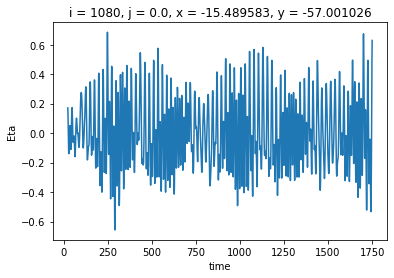

In [24]:
eta_detrend.isel(time=slice(1,1752)).isel(i=0,j=0).plot()

In [9]:
def sinusoid(time, a=0.004,b=0.18,c=1.3,d=-0.123,e=-0.18,f=0.14,g=-0.47,h=-0.15,k=-0.08,l=0.07,m=-0.93):
    return (a+b*np.sin(time*2*np.pi/12.42+c)+d*np.sin(time*2*np.pi/12+e)+f*np.sin(time*2*np.pi/23.92+g)+
        h*np.sin(time*2*np.pi/25.84+k)+l*np.sin(time*2*np.pi/12.66+m))


In [ ]:
for ii in range(0,216):
    print(ii)
    test_curvefit = eta_detrend.isel(i=slice(ii*10,ii*10+10),time=slice(48,-48)).curvefit('time',sinusoid,skipna=False,
                                                                              bounds={"b": (0, 2),"d": (0, 2),"f": (0, 1),"h": (0, 1),"l": (0, 1)})#
    test_curvefit.curvefit_coefficients.to_dataset().to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_coeffs.zarr',append_dim='i')

0
1
2
3
4


In [146]:
coeffs = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/curvefit_coeffs.zarr').isel(i=slice(10,2170))

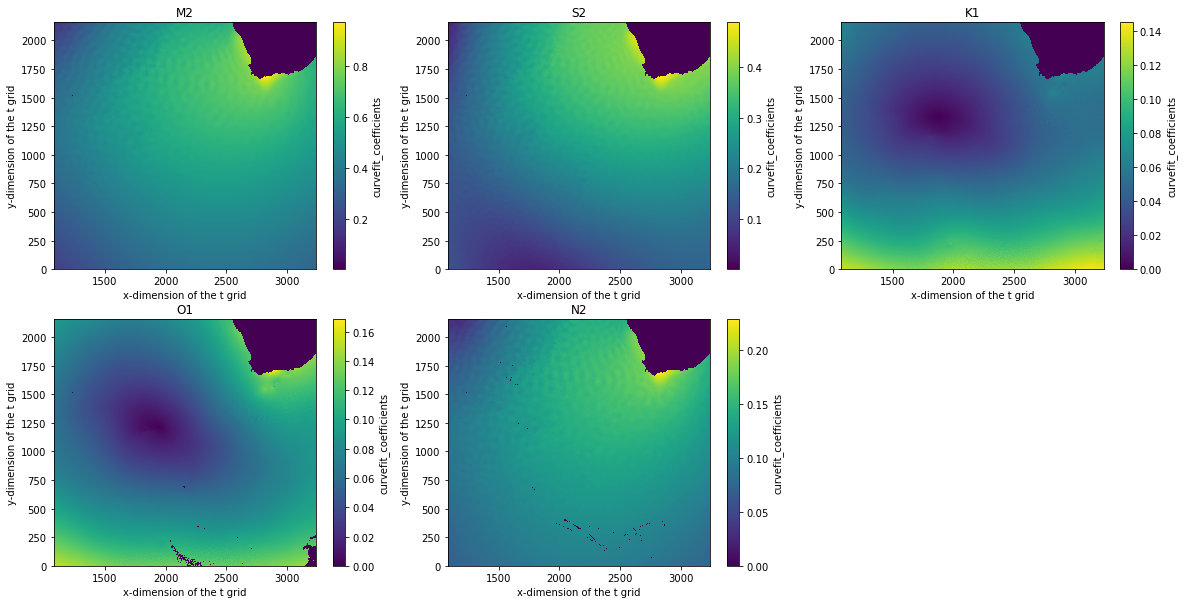

In [147]:
plt.figure(figsize=(20,10))

plt.subplot(231)
coeffs.sel(param='b').curvefit_coefficients.plot()
plt.title('M2')

plt.subplot(232)
coeffs.sel(param='d').curvefit_coefficients.plot()
plt.title('S2')

plt.subplot(233)
coeffs.sel(param='f').curvefit_coefficients.plot()
plt.title('K1')

plt.subplot(234)
coeffs.sel(param='h').curvefit_coefficients.plot()
plt.title('O1')

plt.subplot(235)
coeffs.sel(param='l').curvefit_coefficients.plot()
plt.title('N2')

fig=plt.gcf()

fig.savefig('explicit_fit.png')

In [7]:
new_object=xr.DataArray(np.arange(0,1752),dims=['time'])
new_object = new_object*xr.ones_like(eta_detrend)

In [11]:
#m2_est = xr.apply_ufunc(sinusoid,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
#              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d')
#                        ,coeffs.curvefit_coefficients.sel(param='e'),dask='allowed')

m2_est = xr.apply_ufunc(sinusoid,new_object,coeffs.curvefit_coefficients.sel(param='a'),coeffs.curvefit_coefficients.sel(param='b'),
              coeffs.curvefit_coefficients.sel(param='c'),coeffs.curvefit_coefficients.sel(param='d'),
              coeffs.curvefit_coefficients.sel(param='e'),coeffs.curvefit_coefficients.sel(param='f'),
              coeffs.curvefit_coefficients.sel(param='g'),coeffs.curvefit_coefficients.sel(param='h'),
              coeffs.curvefit_coefficients.sel(param='k'),coeffs.curvefit_coefficients.sel(param='l'),
              coeffs.curvefit_coefficients.sel(param='m'),dask='allowed')

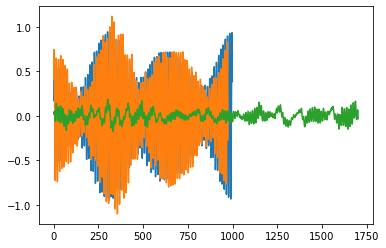

In [25]:
plt.plot(m2_est.isel(i=1000,j=1000,time=slice(0,1000)))
plt.plot(eta_detrend.isel(i=1000,j=1000,time=slice(24,1000)))
plt.plot((eta_detrend.isel(i=1000,j=1000,time=slice(48,2000))-m2_est.isel(i=1000,j=1000,time=slice(0,-48))))

In [130]:
def sinusoid_check(time, a=0.004,b=0.18,c=1.3,d=-0.123,e=-0.18,f=0.14,g=-0.47,h=-0.15,k=-0.08,l=0.07,m=-0.93,n=0.1,o=0.1,p=0.1,q=0.1,r=0.1,s=0.1):
    return (a+b*np.sin(time*2*np.pi/12.421+c)+d*np.sin(time*2*np.pi/12+e)+f*np.sin(time*2*np.pi/23.93+g)+
        h*np.sin(time*2*np.pi/25.82+k)+l*np.sin(time*2*np.pi/12.66+m)+n*np.sin(time*2*np.pi/11.97+o)+p*np.sin(time*2*np.pi/26.88+q)+r*np.sin(time*2*np.pi/26.88+s))

In [143]:
check_it = (eta_detrend.isel(i=1000,j=1000,time=slice(48,2000))).curvefit('time',sinusoid_check,skipna=False,
                                                                              bounds={"b": (0, 2),"d": (0, 2),"f": (0, 1),"h": (0, 1),"l": (0, 1),"o": (0, 1),"q": (0, 1),"s": (0, 1)})

In [144]:
m2_est = xr.apply_ufunc(sinusoid_check,new_object.isel(i=1000,j=1000),check_it.curvefit_coefficients.sel(param='a'),check_it.curvefit_coefficients.sel(param='b'),
              check_it.curvefit_coefficients.sel(param='c'),check_it.curvefit_coefficients.sel(param='d'),
              check_it.curvefit_coefficients.sel(param='e'),check_it.curvefit_coefficients.sel(param='f'),
              check_it.curvefit_coefficients.sel(param='g'),check_it.curvefit_coefficients.sel(param='h'),
              check_it.curvefit_coefficients.sel(param='k'),check_it.curvefit_coefficients.sel(param='l'),
              check_it.curvefit_coefficients.sel(param='m'),check_it.curvefit_coefficients.sel(param='n'),
                        check_it.curvefit_coefficients.sel(param='o'),check_it.curvefit_coefficients.sel(param='p'),
                        check_it.curvefit_coefficients.sel(param='q'),check_it.curvefit_coefficients.sel(param='r'),
                        check_it.curvefit_coefficients.sel(param='s'),dask='allowed')


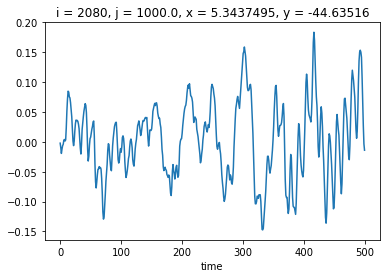

In [145]:
((eta_detrend.isel(i=1000,j=1000,time=slice(48,2000))-m2_est.isel(time=slice(0,-48))).isel(time=slice(0,500))).plot()

In [118]:
plt.plot((eta_detrend.isel(i=1000,j=1000,time=slice(48,2000))-m2_est.isel(i=1000,j=1000,time=slice(0,-48))).isel(time=slice(500,1000)))

ValueError: Dimensions {'j', 'i'} do not exist. Expected one or more of ('time',)

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  warnings.warn(
/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/xrft/xrft.py:49: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in fu

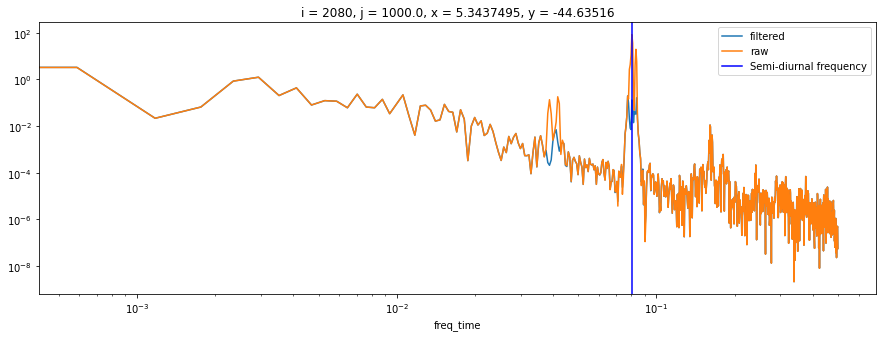

In [27]:
plt.figure(figsize=(15,5))
spect = xrft.power_spectrum((eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(48,2000)).drop_vars('time')-m2_est.isel(i=1000,j=1000,time=slice(0,-48))),dim=['time'], window=True,window_correction=True).compute()
spect[1652//2:].plot(label='filtered')
plt.xscale('log')
plt.yscale('log')

spect = xrft.power_spectrum((eta_timechunks.Eta.isel(i=1000,j=1000,time=slice(48,2000)).drop_vars('time')),dim=['time'], window=True,window_correction=True).compute()
spect[1652//2:].plot(label ='raw')
plt.axvline([1/12.42],label='Semi-diurnal frequency',color='b')
plt.legend()

In [23]:
m2_est.to_dataset(name='tide_est').to_zarr('/swot/SUM02/spencer/swot_agulhas_surf/tide_est.zarr')

In [29]:
m2_est

<xarray.DataArray (time: 1752, j: 2160, i: 2160)>
dask.array<add, shape=(1752, 2160, 2160), dtype=float64, chunksize=(1752, 180, 10), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    x        (j, i) float32 -15.49 -15.47 -15.45 -15.43 ... 29.45 29.47 29.49
    y        (j, i) float32 -57.0 -57.0 -57.0 -57.0 ... -26.66 -26.66 -26.66
Dimensions without coordinates: time

# Rechunk tidal estimate

In [24]:
source = zarr.open('/swot/SUM02/spencer/swot_agulhas_surf/tide_est.zarr')
intermediate = "/swot/SUM02/spencer/swot_agulhas_surf/intermediate.zarr"
target = "/swot/SUM02/spencer/swot_agulhas_surf/tide_rechunk.zarr"

In [30]:
target_chunks = {
    'tide_est': {'time':1,'j':2160,'i':2160},
    'x': {'i':2160, 'j':2160},
    'y': {'i':2160, 'j':2160},
    'iter': None,
    'i': None,
    'j': None,
}

In [32]:
rechunked = rechunk(source, target_chunks=target_chunks,target_store=target,max_mem='800MB',temp_store=intermediate)

In [33]:
rechunked.execute();

_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(0, 310, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(310, 620, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(620, 930, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(930, 1240, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(1240, 1550, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(1550, 1860, None)))
_copy_chunk((slice(0, 1752, None), slice(0, 180, None), slice(1860, 2160, None)))
_copy_chunk((slice(0, 1752, None), slice(180, 360, None), slice(0, 310, None)))
_copy_chunk((slice(0, 1752, None), slice(180, 360, None), slice(310, 620, None)))
_copy_chunk((slice(0, 1752, None), slice(180, 360, None), slice(620, 930, None)))
_copy_chunk((slice(0, 1752, None), slice(180, 360, None), slice(930, 1240, None)))
_copy_chunk((slice(0, 1752, None), slice(180, 360, None), slice(1240, 1550, None)))
_copy_chunk((slice(0, 17

# Make movie

In [34]:
tide_rechunked = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/tide_rechunk.zarr')
tide_rechunked

<xarray.Dataset>
Dimensions:   (i: 2160, j: 2160, time: 1752)
Coordinates:
  * i         (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * j         (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
    x         (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
    y         (j, i) float32 dask.array<chunksize=(2160, 2160), meta=np.ndarray>
Dimensions without coordinates: time
Data variables:
    tide_est  (time, j, i) float64 dask.array<chunksize=(1, 2160, 2160), meta=np.ndarray>

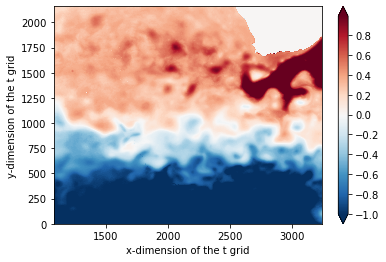

In [35]:
(eta_merged.Eta.drop_vars('time').isel(time=slice(48,2000)).isel(time=0)-tide_rechunked.tide_est.isel(time=slice(0,-48)).isel(time=0)
).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})

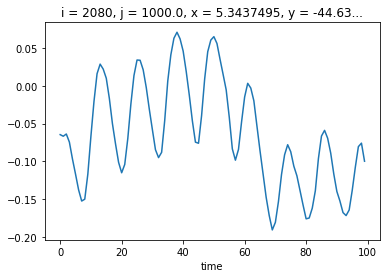

In [49]:
(eta_merged.Eta.drop_vars('time').isel(time=slice(48,2000))-tide_rechunked.tide_est.isel(time=slice(1,-48))-eta_mean
).isel(i=1000,j=1000,time=slice(0,100)).plot()

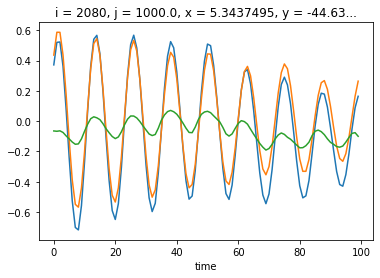

In [56]:
(eta_merged.Eta.drop_vars('time').isel(time=slice(48,2000))-eta_mean).isel(i=1000,j=1000,time=slice(0,100)).plot()
tide_rechunked.tide_est.isel(time=slice(1,-48)).isel(i=1000,j=1000,time=slice(0,100)).plot()
(eta_merged.Eta.drop_vars('time').isel(time=slice(48,2000))-tide_rechunked.tide_est.isel(time=slice(1,-48))-eta_mean
).isel(i=1000,j=1000,time=slice(0,100)).plot()

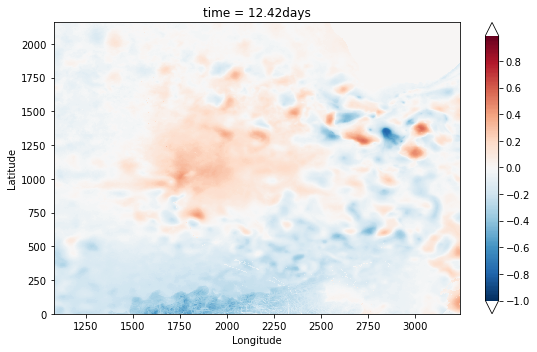

In [44]:
plt.figure(figsize=(8,5))
for tt in range(1,300):
    plt.clf()
    (eta_merged.Eta.drop_vars('time').isel(time=slice(48,2000))-tide_rechunked.tide_est.isel(time=slice(1,-48))-eta_mean).isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_timechunks.time.values[tt]-eta_timechunks.time.values[1]).item()/3600/24/10**9)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))


In [33]:
eta_nobm_slice.time.attrs = {'axis': 'T',
 'calendar': 'gregorian',
 'long_name': 'Time',
 'standard_name': 'time'}

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


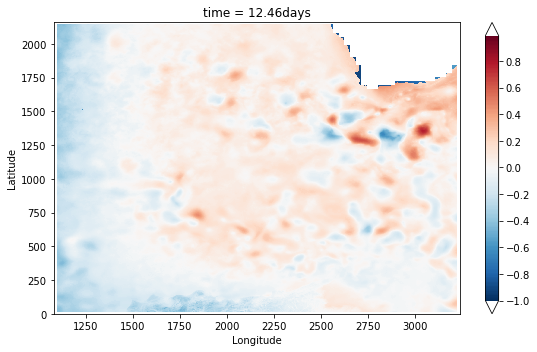

In [32]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_nobm.isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

In [9]:
eta_nobm = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/baro_nom.zarr')

In [25]:
eta_nobm.eta.isel(time=slice(1,2000)).drop_vars('time').chunk({'time':-1})

<xarray.DataArray 'eta' (time: 1751, j: 2160, i: 2160)>
dask.array<rechunk-merge, shape=(1751, 2160, 2160), dtype=float64, chunksize=(1751, 270, 540), chunktype=numpy.ndarray>
Coordinates:
    face     int64 ...
  * i        (i) int64 1080 1081 1082 1083 1084 ... 3235 3236 3237 3238 3239
    iter     (time) int64 dask.array<chunksize=(1751,), meta=np.ndarray>
  * j        (j) float64 0.0 1.0 2.0 3.0 ... 2.157e+03 2.158e+03 2.159e+03
Dimensions without coordinates: time

In [27]:
unfiltered_ps = xrft.power_spectrum(eta.isel(time=slice(1,2000)).drop_vars('time').chunk({'time':-1}),dim=['time'])
filtered_ps = xrft.power_spectrum(eta_nobm.eta.isel(time=slice(1,2000)).drop_vars('time').chunk({'time':-1}),dim=['time'])

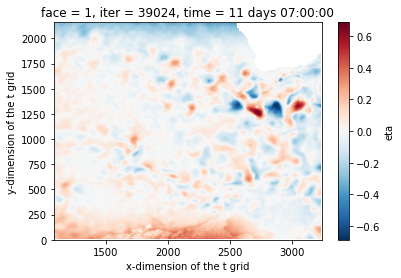

In [65]:
eta_nobm.eta.isel(time=200).plot()

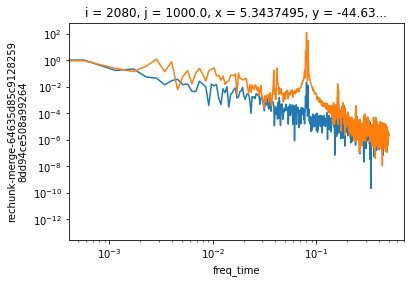

In [67]:
filtered_ps[875:,1000,1000].plot()
unfiltered_ps[875:,1000,1000].plot()
plt.xscale('log')
plt.yscale('log')

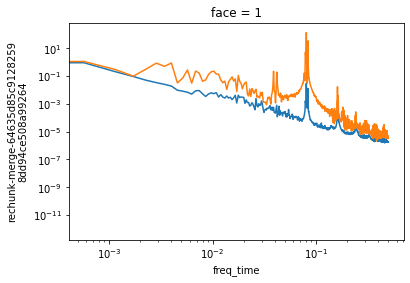

In [60]:
filtered_ps[875:,920:-920,850:-850].mean(['i','j']).plot()
unfiltered_ps[875:,920:-920,850:-850].mean(['i','j']).plot()
plt.xscale('log')
plt.yscale('log')

In [33]:
def lin_func(s, a=1, b=1, c=1):
    x,y=s
    return a * x+ b * y + c

In [59]:
fit_eta_unf = eta.where(eta.isel(time=20)!=0).chunk({'i':-1,'j':-1}).curvefit(["i","j"],func=lin_func,p0={"a":1,"b":1,"c":1})
fit_surface_unf = lin_func((eta.i,eta.j),fit_eta_unf.curvefit_coefficients.sel(param='a'), 
                       fit_eta_unf.curvefit_coefficients.sel(param='b'), fit_eta_unf.curvefit_coefficients.sel(param='c'))
eta_detr = (eta-fit_surface_unf.where((eta.isel(time=20)!=0)) )

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/core.py:4337: PerformanceWarning: Increasing number of chunks by factor of 32
  result = blockwise(


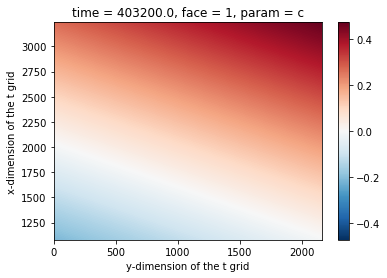

In [62]:
fit_surface_unf.isel(time=40).plot()

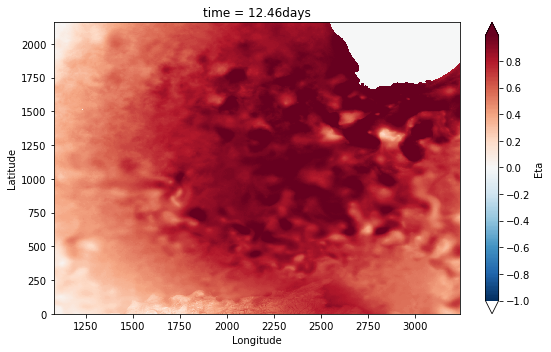

In [63]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta.isel(time=tt).plot.pcolormesh(levels=np.arange(-1,1,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

In [164]:
bathy = np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/bathy_llc_4320_agulhas.bin',dtype='>f4').reshape(2160,2160)

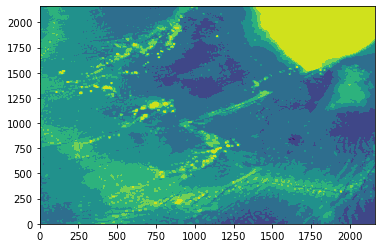

In [176]:
plt.contourf(bathy)

In [172]:
bathy2 = bathy*velmask.values
bathy2.astype('>f4').tofile('/home/spencerj/agulhas-offline/input_agulhas/bathymasked_ag.bin')

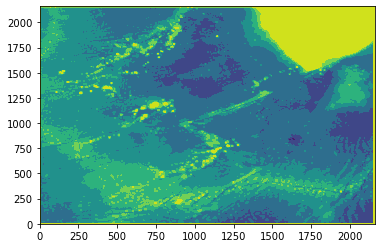

In [175]:
test = np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/bathymasked_ag.bin',dtype='>f4').reshape(2160,2160)
plt.contourf(test)

In [ ]:
outdir='/swot/SUM03/spencer/swot_eta_nobaro/'
for i in range(0,1751):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    eta = eta_nob.isel(time=0).fillna(0).values
    output_binary_file(eta, os.path.join(outdir, 'eta_nob.%010d.data' % Nt))

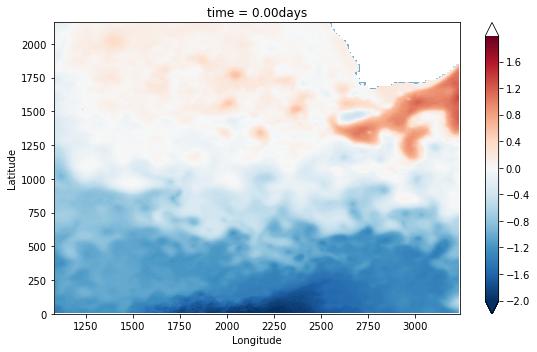

In [125]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_nob.isel(time=tt).plot.pcolormesh(x='i',y='j',levels=np.arange(-2,2,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_filtered.time.values[tt]-eta_filtered.time.values[0]).astype('f')/3600/24/10**9)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta_filt/fig{:03d}.jpg".format(tt))

/home/spencerj/.conda/envs/base2/envs/test_gcm_filters/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


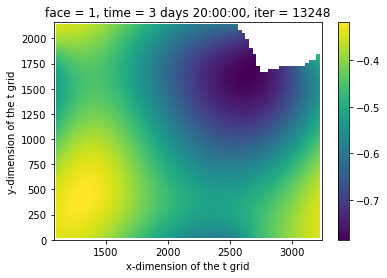

In [53]:
eta_filtered_mr.isel(time=20).interp_like(eta.isel(time=20)).plot(x='i')

In [12]:
eta_coarsened.j

<xarray.DataArray 'i' (i: 540)>
array([1081.5, 1085.5, 1089.5, ..., 3229.5, 3233.5, 3237.5])
Coordinates:
    face     int64 1
  * i        (i) float64 1.082e+03 1.086e+03 1.09e+03 ... 3.234e+03 3.238e+03
    iter     int64 10368
    time     timedelta64[ns] 3 days
Attributes:
    axis:           X
    long_name:      x-dimension of the t grid
    standard_name:  x_grid_index
    swap_dim:       XC

In [ ]:
outdir='/swot/SUM03/spencer/swot_trimmed/'
for i in range(0,5):
    if np.mod(i,10)==0:
        print(i)
    nt = 10368 + i*144
    Nt = nt - 10368
    ds = xr.open_dataset(indir + 'llc_4320_agulhas.%010d.nc' %nt)
    theta = ds.Theta[0].isel(k=slice(0,30)).values
    salt = ds.Salt[0].isel(k=slice(0,30)).values
    eta = ds.Eta[0].values
    uvel = ds.U[0].isel(k=slice(0,30)).values
    vvel = ds.V[0].isel(k=slice(0,30)).values
    #output_binary_file(theta, os.path.join(outdir, 'theta.%010d.data' % Nt))
    #output_binary_file(salt, os.path.join(outdir, 'salt.%010d.data' % Nt))
    #output_binary_file(eta, os.path.join(outdir, 'eta.%010d.data' % Nt))
    #output_binary_file(uvel, os.path.join(outdir, 'uvel.%010d.data' % Nt))
    #output_binary_file(vvel, os.path.join(outdir, 'vvel.%010d.data' % Nt))
    ds.close()

In [198]:
test1 = np.fromfile('/swot/SUM03/spencer/swot_eta_nobaro/eta_nob.0000252000.data',dtype='>f4')
test2 = np.fromfile('/swot/SUM03/spencer/swot_eta_nobaro/eta_nob.0000149904.data',dtype='>f4')

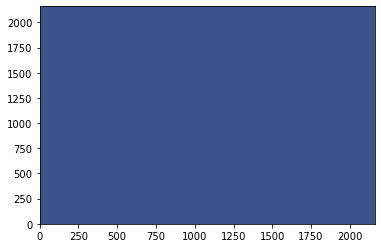

In [199]:
plt.contourf(test1.reshape(2160,2160)-test2.reshape(2160,2160))